In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

# Print out GPU info
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
else:
    print(gpu_info)

    
# Virtual Memory
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))
CUDA_VISIBLE_DEVICES=2

Wed Oct  5 15:29:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.85.02    Driver Version: 510.85.02    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| 25%   34C    P0    27W / 120W |    406MiB /  6144MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [10]:

# for data load
import datetime, os

# for reading and processing images
import imageio
from PIL import Image, ImageOps


from IPython.display import clear_output
# for visualizations
import matplotlib.pyplot as plt

import numpy as np # for using np arrays

# for bulding and running deep learning model

import tensorflow as tf
from tensorflow import keras as K
from tensorflow.keras.utils import get_source_inputs
print(tf.__version__)

import numpy as np
import scipy.stats as sp
import matplotlib.pyplot as plt
import pandas as pd
import time

# SM_FRAMEWORK=K
SM_FRAMEWORK=tf.keras
import segmentation_models as sm

sm.set_framework('tf.keras')
K.backend.set_image_data_format('channels_last')
from segmentation_models import get_preprocessing
seed=25
tf.random.set_seed(seed)
np.random.seed(seed)
AUTOTUNE = tf.data.AUTOTUNE

2.8.0


In [32]:
BACKBONE = 'efficientnetb3'
# BACKBONE = 'resnet50'
preprocess_input = get_preprocessing(BACKBONE)

In [52]:
model = sm.Unet(BACKBONE ,input_shape=(128, 128, 3),classes=10,activation='softmax', encoder_weights='imagenet')

In [ ]:
model.summary()

In [55]:
model.load_weights("../data/best_efficientnetb3_unet1.h5")


In [7]:
def parse_image(img_path: str) -> dict:
    """Load an image and its annotation (mask) and returning
    a dictionary.

    Parameters
    ----------
    img_path : str
        Image (not the mask) location.
        For one Image path:
        .../dataset/images/image1.jpg
        Its corresponding annotation path is:
        .../dataset/masks/masks1.png

    Returns
    -------
    dict
        Dictionary mapping an image and its mask.
    """
    image = tf.io.read_file(img_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.uint8)

    
    mask_path = tf.strings.regex_replace(img_path, "images", "masks")
    mask = tf.io.read_file(mask_path)
    # The masks contain a class index for each pixels
    mask = tf.image.decode_png(mask, channels=1)
    # Since 255 exist, changing it with 0
    mask = tf.where(mask == 255, np.dtype('uint8').type(0), mask)
    return {'image': image, 'segmentation_mask': mask}

@tf.function
def normalize(input_image: tf.Tensor, input_mask: tf.Tensor) -> tuple:
    """Rescale the pixel values of the images between 0.0 and 1.0
    compared to [0,255] originally.

    Parameters
    ----------
    input_image : tf.Tensor
        Tensorflow tensor containing an image of size [SIZE,SIZE,3].
    input_mask : tf.Tensor
        Tensorflow tensor containing an mask of size [SIZE,SIZE,1].

    Returns
    -------
    tuple
        Normalized image and its masks.
    """
    input_image = tf.cast(input_image, tf.float32) / 255.0
    
    #added later, verify and check wheter to use normalize on masks
#     input_mask = tf.cast(input_mask, tf.float32) / 255.0
    return input_image, input_mask
   

@tf.function
def load_image_train(datapoint: dict) -> tuple:
    """Apply some transformations to an input dictionary
    containing a train image and its mask.

    Notes
    -----
    An annotation is a regular  channel image.
    If a transformation such as rotation is applied to the image,
    the same transformation has to be applied on the mask also.

    Parameters
    ----------
    datapoint : dict
        A dict containing an image and its mask.

    Returns
    -------
    tuple
        A modified image and its mask.
    """
    print(datapoint['image'])
    input_image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_SIZE, IMG_SIZE))

    
    if tf.random.uniform(()) > 0.5:
          input_image = tf.image.flip_left_right(input_image)
          input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask   

@tf.function
def load_image_test(datapoint: dict) -> tuple:
    """Apply some transformations to an input dictionary
    containing a train image and its mask.

    Notes
    -----
    An annotation is a regular  channel image.
    If a transformation such as rotation is applied to the image,
    the same transformation has to be applied on the mask also.

    Parameters
    ----------
    datapoint : dict
        A dict containing an image and its mask.

    Returns
    -------
    tuple
        A modified image and its mask.
    """
#     print(datapoint['image'])
    input_image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_SIZE, IMG_SIZE))

    
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask       

In [12]:

# dataset_path = '/content/drive/MyDrive/Thesis/drive/MyDrive/dataset/images/'
dataset_path = '../../dataset/images/'

all_dataset = tf.data.Dataset.list_files(dataset_path + "*.png", seed=seed)


In [13]:
test_dataset = all_dataset.take(288) 
train_dataset = all_dataset.skip(290)

TRAINSET_SIZE = len(train_dataset)
VALSET_SIZE= len(test_dataset)

print(f"The Training Dataset contains {TRAINSET_SIZE} images.")
print(f"The Training Dataset contains {VALSET_SIZE} images.")
print(tf.__version__)

The Training Dataset contains 1152 images.
The Training Dataset contains 288 images.
2.8.0


In [14]:
IMG_SIZE=128
BATCH_SIZE = 4 #32
BUFFER_SIZE = 500

train_dataset = train_dataset.map(parse_image)
test_dataset = test_dataset.map(parse_image)

dataset = {"train": train_dataset, "val": test_dataset}

dataset['train'] = dataset['train'].map(load_image_train)
dataset['train'] = dataset['train'].shuffle(buffer_size=BUFFER_SIZE, seed=seed)
dataset['train'] = dataset['train'].repeat()
dataset['train'] = dataset['train'].batch(BATCH_SIZE)
dataset['train'] = dataset['train'].prefetch(buffer_size=AUTOTUNE)


dataset['val'] = dataset['val'].map(load_image_test)
dataset['val'] = dataset['val'].repeat()
dataset['val'] = dataset['val'].batch(BATCH_SIZE)
dataset['val'] = dataset['val'].prefetch(buffer_size=AUTOTUNE)

print(dataset['train'])
print(dataset['val'])

Tensor("datapoint:0", shape=(None, None, 3), dtype=uint8)
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.float32, name=None))>


tf.Tensor(
[[[[0.32352942 0.21372549 0.12745099]
   [0.39362746 0.26421568 0.18970588]
   [0.3779412  0.23284313 0.15833333]
   ...
   [0.5058824  0.4509804  0.4       ]
   [0.46960783 0.41617647 0.38088235]
   [0.4985294  0.43333334 0.3720588 ]]

  [[0.31323528 0.19166666 0.10931373]
   [0.3612745  0.23186274 0.15735294]
   [0.33431372 0.19411765 0.09950981]
   ...
   [0.38235295 0.31176472 0.2637255 ]
   [0.5377451  0.4872549  0.4504902 ]
   [0.45147058 0.3970588  0.35490197]]

  [[0.34411764 0.22254902 0.14411765]
   [0.30637255 0.18480392 0.11421569]
   [0.34460783 0.20735294 0.12107843]
   ...
   [0.4122549  0.327451   0.27598038]
   [0.529902   0.4759804  0.4245098 ]
   [0.47107843 0.42009804 0.3887255 ]]

  ...

  [[0.10637255 0.07058824 0.03480392]
   [0.09166667 0.05539216 0.02843137]
   [0.10294118 0.06813726 0.03186275]
   ...
   [0.5421569  0.32352942 0.19362745]
   [0.29166666 0.1127451  0.03627451]
   [0.20294118 0.10245098 0.05098039]]

  [[0.16568628 0.10392157 0.046078

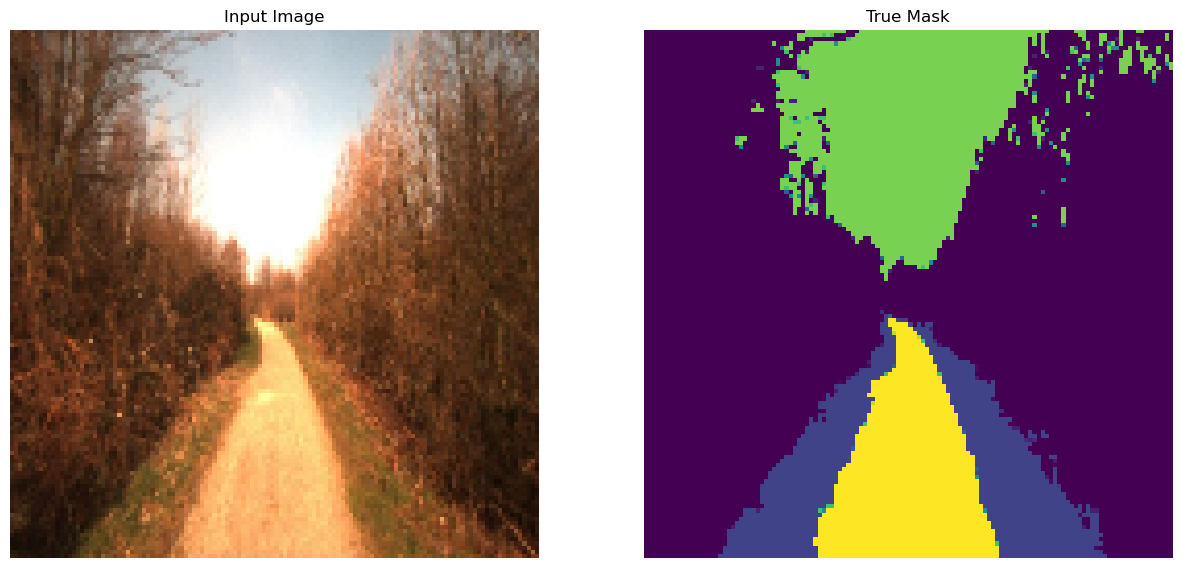

In [41]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def epoch_end(self, epoch, logs=None):
        clear_ouput(wait=True)
        show_predictions()
        print('Sample Predictions {}\n'.format(epoch+1))
        

def display_sample(display_list):
    """Show side-by-side an input image,
    the ground truth and the prediction.
    """
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()


def show_predictions(dataset=None, num=1):
    """Show a sample prediction.

    Parameters
    ----------
    dataset : [type], optional
        [Input dataset, by default None
    num : int, optional
        Number of sample to show, by default 1
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            pred_mask = tf.argmax(pred_mask, axis=-1)
            pred_mask = tf.expand_dims(pred_mask, axis=-1)
            display_sample([image[0], true_mask, pred_mask])
    else:
        # The model is expecting a tensor of the size
        # [BATCH_SIZE, IMG_SIZE, IMG_SIZE, 3]
        # but sample_image[0] is [IMG_SIZE, IMG_SIZE, 3]
        # and we want only 1 inference to be faster
        # so we add an additional dimension [1, IMG_SIZE, IMG_SIZE, 3]
        one_img_batch = sample_image[0][tf.newaxis, ...]
        # one_img_batch -> [1, IMG_SIZE, IMG_SIZE, 3]
        inference = model.predict(one_img_batch)
        # inference -> [1, IMG_SIZE, IMG_SIZE, N_CLASS]
        inference = tf.argmax(inference, axis=-1)
        pred_mask = tf.expand_dims(inference, axis=-1)
#         pred_mask = create_mask(inference)
        # pred_mask -> [1, IMG_SIZE, IMG_SIZE, 1]
        display_sample([sample_image[0], sample_mask[0],
                        pred_mask[0]])    
for image, mask in dataset['train'].take(1):
    sample_image, sample_mask = image, mask
    print(sample_image)

# print(sample_image)
display_sample([sample_image[0], sample_mask[0]])

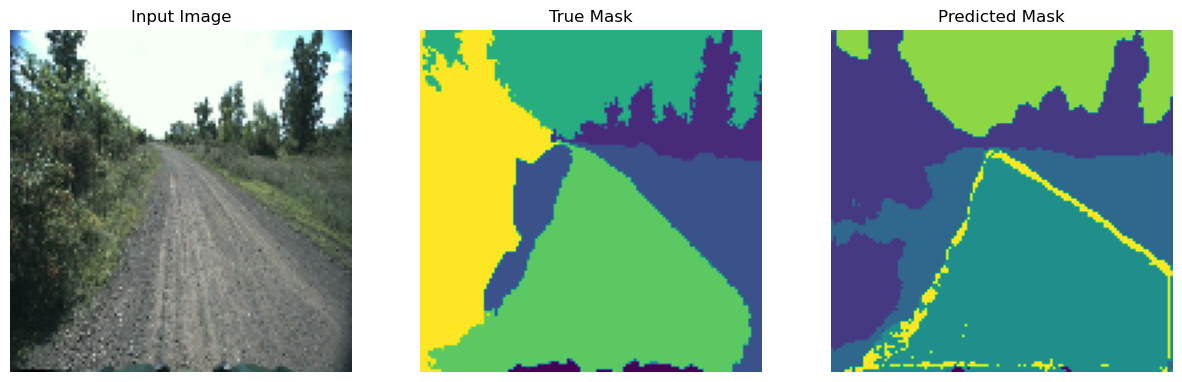

In [59]:
for image, mask in dataset['train'].take(1):
    sample_image, sample_mask = image, mask
show_predictions()

In [56]:

dice_loss = sm.losses.DiceLoss() 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

model.compile(
    K.optimizers.Adam(0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
#     loss=total_loss,
#     metrics=[sm.metrics.IOUScore(), sm.metrics.FScore()],
    metrics=[sm.metrics.IOUScore(), 'accuracy']
)

In [57]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

callbacks = [
    # to show samples after each epoch
    DisplayCallback(),
    # to collect some useful metrics and visualize them in tensorboard
    tensorboard_callback,
    # if no accuracy improvements we can stop the training directly
#     tf.keras.callbacks.EarlyStopping(patience=10, verbose=1),
    # to save checkpoints
    tf.keras.callbacks.ModelCheckpoint('best_efficientnetb3_unet.h5', verbose=1, save_best_only=True, save_weights_only=False)
]


In [51]:
# STEPS_PER_EPOCH = TRAINSET_SIZE // BATCH_SIZE
# VALIDATION_STEPS = VALSET_SIZE // BATCH_SIZE

results = model.fit(
   dataset['train'],
   epochs=100,
   steps_per_epoch = TRAINSET_SIZE // BATCH_SIZE,
   validation_steps= VALSET_SIZE // BATCH_SIZE,
   validation_data=dataset['val'],
   callbacks=callbacks
)

Epoch 1/100
288/288 [==============================] - ETA: 0s - loss: 2.3283 - iou_score: 0.1079 - accuracy: 0.3431

2022-10-05 16:13:45.376708: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1300561920 exceeds 10% of free system memory.



Epoch 1: val_loss improved from inf to 2.25259, saving model to best_efficientnetb3_unet.h5
288/288 [==============================] - 183s 596ms/step - loss: 2.3283 - iou_score: 0.1079 - accuracy: 0.3431 - val_loss: 2.2526 - val_iou_score: 0.1073 - val_accuracy: 0.2859
Epoch 2/100
288/288 [==============================] - ETA: 0s - loss: 2.2128 - iou_score: 0.1071 - accuracy: 0.3122

2022-10-05 16:16:35.480522: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1300561920 exceeds 10% of free system memory.



Epoch 2: val_loss improved from 2.25259 to 2.22153, saving model to best_efficientnetb3_unet.h5
288/288 [==============================] - 170s 591ms/step - loss: 2.2128 - iou_score: 0.1071 - accuracy: 0.3122 - val_loss: 2.2215 - val_iou_score: 0.1071 - val_accuracy: 0.2843
Epoch 3/100
288/288 [==============================] - ETA: 0s - loss: 2.2148 - iou_score: 0.1071 - accuracy: 0.2765

2022-10-05 16:19:25.508918: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1300561920 exceeds 10% of free system memory.



Epoch 3: val_loss improved from 2.22153 to 2.21443, saving model to best_efficientnetb3_unet.h5
288/288 [==============================] - 170s 591ms/step - loss: 2.2148 - iou_score: 0.1071 - accuracy: 0.2765 - val_loss: 2.2144 - val_iou_score: 0.1071 - val_accuracy: 0.2627
Epoch 4/100
181/288 [=================>............] - ETA: 58s - loss: 2.2156 - iou_score: 0.1071 - accuracy: 0.2387

KeyboardInterrupt: 

In [58]:
# STEPS_PER_EPOCH = TRAINSET_SIZE // BATCH_SIZE
# VALIDATION_STEPS = VALSET_SIZE // BATCH_SIZE

results = model.fit(
   dataset['train'],
   epochs=100,
   steps_per_epoch = TRAINSET_SIZE // BATCH_SIZE,
   validation_steps= VALSET_SIZE // BATCH_SIZE,
   validation_data=dataset['val'],
   callbacks=callbacks
)

Epoch 1/100
288/288 [==============================] - ETA: 0s - loss: 1.5233 - iou_score: 0.1095 - accuracy: 0.5119
Epoch 1: val_loss improved from inf to 1.50098, saving model to best_efficientnetb3_unet.h5
288/288 [==============================] - 183s 598ms/step - loss: 1.5233 - iou_score: 0.1095 - accuracy: 0.5119 - val_loss: 1.5010 - val_iou_score: 0.1118 - val_accuracy: 0.5210
Epoch 2/100
288/288 [==============================] - ETA: 0s - loss: 0.9746 - iou_score: 0.1126 - accuracy: 0.6715
Epoch 2: val_loss improved from 1.50098 to 0.89927, saving model to best_efficientnetb3_unet.h5
288/288 [==============================] - 170s 589ms/step - loss: 0.9746 - iou_score: 0.1126 - accuracy: 0.6715 - val_loss: 0.8993 - val_iou_score: 0.1138 - val_accuracy: 0.7011
Epoch 3/100
 22/288 [=>............................] - ETA: 2:31 - loss: 0.8659 - iou_score: 0.1141 - accuracy: 0.7112

KeyboardInterrupt: 

In [9]:
def norm(Z):
    """Compute norms over all but the first dimension"""
    return tf.norm(tf.reshape(Z, (Z.shape[0], -1)), axis=1)

# PGD L2 for Adversarial Examples #
"""PGD.

    Parameters
    ----------
    Model : [type], optional
        [Input dataset, by default None
    X,y : int, optional
        Number of sample to show, by default 1
    alpha : 
    epsilon:
    delta : 
    """
def single_pgd_step_adv(model, X, y, alpha, epsilon, delta):
    with tf.GradientTape() as tape:
        tape.watch(delta)
        loss = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=False,
            reduction=tf.keras.losses.Reduction.NONE # Use no aggregation - will give gradient separtely for each ex.
            )(y, model(X + delta)) # comparing to label for original data point
    grad = tape.gradient(loss, delta)

    normgrad = tf.reshape(norm(grad), (-1, 1, 1, 1))
    z = delta + alpha * (grad / (normgrad + 1e-10))

    normz = tf.reshape(norm(z), (-1, 1, 1, 1))
    delta = epsilon * z / (tf.math.maximum(normz, epsilon) + 1e-10)
    return delta, loss

def pgd_l2_adv(model, X, y, alpha, num_iter, epsilon=0, example=False):
    fn = tf.function(single_pgd_step_adv)
    delta = tf.zeros_like(X)
    loss = 0
    for t in range(num_iter):
        delta, loss = fn(model, X, y, alpha, epsilon, delta)
        
    if example:
        print(f'{num_iter} iterations, final MSE {loss}')
    return delta

# Helper for pgd_linf
@tf.function
def onestep_pgd_linf(model, X, y, epsilon, alpha, delta):
    with tf.GradientTape() as tape:
        tape.watch(delta)
        loss = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=False,
            reduction=tf.keras.losses.Reduction.NONE
        )(y, model(X + delta))

    delta = tf.clip_by_value(delta + alpha*tf.sign(tape.gradient(loss, delta)), X-epsilon, X+epsilon)
    
    return delta


def pgd_linf(model, X, y, epsilon, alpha, num_iter):
    """ Construct FGSM adversarial examples on the examples X"""
    delta = tf.zeros_like(X)
    for t in range(num_iter):
        delta = onestep_pgd_linf(model, X, y, epsilon, alpha, delta)
    return delta


@tf.function
def fgsm_attack(model, X, y, epsilon=0.1):
    delta = tf.zeros_like(X)
    
    # use GradientTape to perform autodiff
    with tf.GradientTape() as tape:
        # specifically 'watch' delta
        # see here: https://www.tensorflow.org/guide/autodiff
        tape.watch(delta)
        loss = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=False,
            reduction=tf.keras.losses.Reduction.NONE
        )(y, model(X + delta))
    delta = tf.sign(tape.gradient(loss, delta)) * epsilon
    return delta


In [10]:
def single_pgd_step_robust(model, X, y, alpha, delta):
    with tf.GradientTape() as tape:
        tape.watch(delta)
        loss = tf.keras.losses.MeanSquaredError(
            reduction=tf.keras.losses.Reduction.NONE
        )(y, model(X + delta)) # comparing to robust model representation layer
        
    grad = tape.gradient(loss, delta)
    normgrad = tf.reshape(norm(grad), (-1, 1, 1, 1))
    delta -= alpha*grad / (normgrad + 1e-10) # normalized gradient step
    delta = tf.math.minimum(tf.math.maximum(delta, -X), 1-X) # clip X+delta to [0,1]
    return delta, loss

def pgd_l2_robust(model, X, y, alpha, num_iter, epsilon=0, example=False):
    delta = tf.zeros_like(X)
    loss = 0
    fn = tf.function(single_pgd_step_robust)
    for t in range(num_iter):
      delta, loss = fn(model, X, y, alpha, delta)
    # Prints out loss to evaluate if it's actually learning (currently broken)
    if example:
        print(f'{num_iter} iterations, final MSE {loss}')
    return delta


def single_pgd_step_nonrobust(model, X, y, alpha, epsilon, delta):
    with tf.GradientTape() as tape:
        tape.watch(delta)
        loss = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=False,
            reduction=tf.keras.losses.Reduction.NONE # Use no aggregation - will give gradient separtely for each ex.
            )(y, model(X + delta)) # comparing to label for original data point
    grad = tape.gradient(loss, delta) #tape.gradient(loss, delta)

    # equivalent to delta += alpha*grad / norm(grad), just for batching
    normgrad = tf.reshape(norm(grad), (-1, 1, 1, 1))
    # changed from plus to minus b/c trying to minimize with non-robust
    z = delta - alpha * (grad / (normgrad + 1e-10))
    normz = tf.reshape(norm(z), (-1, 1, 1, 1))
    delta = epsilon * z / (tf.math.maximum(normz, epsilon) + 1e-10)
    return delta, loss

def pgd_l2_nonrobust(model, X, y, alpha, num_iter, epsilon=0, example=False):
    fn = tf.function(single_pgd_step_nonrobust)
    delta = tf.zeros_like(X)
    loss = 0
    for t in range(num_iter):
        delta, loss = fn(model, X, y, alpha, epsilon, delta)
        
    if example:
        print(f'{num_iter} iterations, final MSE {loss}')
    return delta   

In [10]:
def run_adversarial_attack(model, valid_dataset , attack, attack_params=None, **kwargs):
    """Runs only the adversarial attack on a trained model. 
    
    Differs from standard training by skipping the gradient updates which can be highly costly. Can be
    demonstrated from training model in standard way and then applying"""
    # Convert function to tf function
    attack_fn = tf.function(attack)

    t = time.time()
    test_losses = []
    test_accs = []
#     print(valid_dataset.length())
    for Xtest, ytest in valid_dataset:         
        # Run attack perturbation
        if attack_params is not None:
            delta = attack_fn(model, Xtest, ytest, **attack_params)
        else:
            delta = attack_fn(model, Xtest, ytest, **kwargs)
        
#         print(delta)
        Xdtest = Xtest + delta
        l, acc, *is_anything_else_being_returned = model.test_on_batch(Xdtest, ytest)
        print(l)
        clear_output(wait=True)
        test_losses.append(l)
        test_accs.append(acc)
    
    test_loss = sum(test_losses) / len(test_losses)
    test_acc = sum(test_accs) / len(test_accs)
    print(f"Time: {(time.time()-t):0.2f} Test Loss: {test_loss:0.2f}, Test Acc: {test_acc:0.2f}")

In [ ]:
# PGD L2 attack
run_adversarial_attack(model, dataset['val'].take(32), attack=pgd_l2_adv, 
                       attack_params={'alpha':0.5/5, 'num_iter':7, 'epsilon':0.25 })

In [ ]:
# PGD L-infinity attack
run_adversarial_attack(model, dataset['val'].take(32), attack=pgd_linf, 
                       attack_params={'alpha':0.5/5, 'num_iter':7, 'epsilon':0.25 }) # {'epsilon':0.5, 'num_iter':7, 'alpha':0.5/5}

In [ ]:
# FGSM attack
run_adversarial_attack(model, dataset['val'].take(32), attack=fgsm_attack, 
                       attack_params={'epsilon':0.25})

In [ ]:
def adversarial_training(model, train_ds, test_ds, train_attack=pgd_l2_adv, test_attack=None, epochs=5, verbose=True, test_kwargs=None, **kwargs):
    """Runs the "adversarial" training loop described in Ilyas et al. (2019)
    
    Adversarial training allows for two separate attacks, one during training and a separate one during
    test. Note that if 'train_attack' is set to None, then this becomes standard training.
    
    Args:
        - model (TFModel): A compiled TF / Keras model
        - train_ds (TFData): a tensorflow data object for the training data
        - test_ds (TFData): a tensorflow data object for the test data 
        - attack (function): an attack function (i.e. PGD L2) to perturb
                test data if evaluating adversarial performance. Default : None
        - epochs (int): number of epochs to run training. Default: 5.
        - verbose (bool): Report results after each epoch. Otherwise
                will return the train / test accuracies at the end of training. 
                Default: True"""

    # Create train and test functions wrapped
    if train_attack is not None:
      train_attack_tf = tf.function(train_attack)
    if test_attack is not None:
      test_attack_tf = tf.function(test_attack)

    for n in range(epochs):
#         print(n)
        t = time.time()
        train_losses = []
        train_accs = []
        for b in train_ds:
            X, y = b
#             print("here")
            # Create adversarially perturbed training data
            if train_attack is not None:
                delta = train_attack_tf(model, X, y, **kwargs)
                Xd = X + delta
            else:
                Xd = X  
            # Train model on adversarially perturbed data
            l, l1, acc, other_returned_val = model.train_on_batch(Xd, y)
#             print(acc)
            train_losses.append(l)
            train_accs.append(acc)

        test_losses = []
        test_accs = []
        for vb in test_ds:
            Xtest, ytest = vb
            
            # When attack is specified (ie not None), apply
            # attack at test time; do not apply in training due to
            # 'standard_training' definition
            if test_attack is not None:
                if isinstance(test_kwargs, dict):
                    delta = test_attack_tf(model, Xtest, ytest, **test_kwargs)
                else:
                    delta = test_attack_tf(model, Xtest, ytest)
                Xdtest = Xtest + delta
            else:
                # when test_attack is not specified 
                Xdtest = Xtest
            
            l, l1, acc, other_returned_val = model.test_on_batch(Xdtest, ytest)
#             print({l}, {acc}, {other_returned_val})
            test_losses.append(l)
            test_accs.append(acc)
        
        train_loss = sum(train_losses) / len(train_losses)
        train_acc = sum(train_accs) / len(train_accs)
        
        test_loss = sum(test_losses) / len(test_losses)
        test_acc = sum(test_accs) / len(test_accs)
        
        if verbose:
            print(f"Epoch {n}/{epochs}, Time: {(time.time()-t):0.2f} -- Train Loss: {train_loss:0.2f}, \
                Train Acc: {train_acc:0.2f}, Test Loss: {test_loss:0.2f}, Test Acc: {test_acc:0.2f}")
    
    # Return final train and test losses
    if verbose == False:
        return {'train_loss': train_loss, 'train_acc': train_acc, 'test_loss': test_loss, 'test_acc': test_acc}

In [11]:
adv_train_model = sm.Unet(BACKBONE ,input_shape=(128, 128, 3),classes=10,
                activation='softmax', encoder_weights='imagenet')

In [12]:
# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=seed)

dice_loss = sm.losses.DiceLoss() 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# adv_train_model.compile(
#     K.optimizers.Adam(0.0001),
#     loss=total_loss,
#     metrics=[sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5), "accuracy"],
# )
boundaries = [15000, 20000]
values = [0.1, 0.01, 1e-3]
learning_rate_fn = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries, values)

# l, l1, acc, other_returned_val = model.train_on_batch(Xd, y)

tf.keras.backend.clear_session()
adv_train_model.compile(
    loss=total_loss, 
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate_fn, 
                                       momentum=0.9),
    metrics=[sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5), "accuracy"]
)


In [ ]:
adversarial_training(adv_train_model, dataset['train'].take(1152), dataset['val'].take(288), train_attack=pgd_l2_adv, 
                     epsilon=0.5, num_iter=7, alpha=0.5 / 5, epochs=25000 // 391)

In [ ]:
# Save the model
adv_train_model.save_weights('../data/adv_training_resnet50.h5')


In [13]:
adv_train_model.load_weights('../data/adv_training_efficientnet.h5')

In [ ]:
adv_train_model.summary()

## Robustifier

In [14]:
# Create the robustifier model 
# (which is the adversarially trained model without the last layer)
# adv_training.summary()
representation = adv_train_model.layers[-6]
robustifier = tf.keras.Model(inputs = adv_train_model.layers[0].input, 
                             outputs = representation.output)
# robustifier.summary()



## Create Robust Dataset

In [15]:
def robust_preprocess(img, label):
    """Defines preprocessing / data augmentation for robust & nonrobust features"""
    img = tf.image.resize_with_pad(img, 32+4, 32+4)
    img = tf.image.random_crop(img, size=[32, 32, 3])
    img = tf.image.stateless_random_flip_left_right(img, (15, 13))
    return img, label

In [ ]:
import gc
%%time
def robustify(robust_mod, train_ds, iters=1000, alpha=0.1, batch_size=4):
    robust_train = []
    orig_labels = []
    example = False

    train_to_pull = list(iter(train_ds))
    start_rn = np.random.randint(0, len(train_ds))
    rand_batch = train_to_pull[start_rn][0]

    start_time = time.time()
    for i, (img_batch, label_batch) in enumerate(train_ds):
        inter_time = time.time()  

        # For the last batch, it is smaller than batch_size and thus we match the size for the batch of initial images
        if img_batch.shape[0] < batch_size:
            rand_batch = rand_batch[:img_batch.shape[0]]

        # Get the goal representation
        goal_representation = robust_mod(img_batch)
      
        # Upate the batch of images
        learned_delta = pgd_l2_robust(robust_mod, rand_batch, goal_representation, alpha=alpha, num_iter=iters)
        robust_update = (rand_batch + learned_delta)

        # Add the updated images and labels to their respective lists
        robust_train.append(robust_update)
        orig_labels.append(label_batch)
      
        # Measure the time
        if (i+1) % 10 == 0:
            elapsed = time.time() - start_time
            elapsed_tracking = time.time() - inter_time
            print(f'Robustified {(i+1)*batch_size} images in {elapsed:0.3f} seconds; Took {elapsed_tracking:0.3f} seconds for this particular iteration')    
      
      # Reset random image batch
        rn = np.random.randint(0, len(train_ds)-1) # -1 because last batch might be smaller
        rand_batch = train_to_pull[rn][0]
        
        robust_trainset = tf.data.Dataset.from_tensor_slices((tf.concat(robust_train, axis=0), tf.concat(orig_labels, axis=0)))
        robust_trainset = robust_trainset.prefetch(AUTOTUNE)

        robust_ds = robust_trainset.map(robust_preprocess, num_parallel_calls=AUTOTUNE)
        robust_ds = robust_ds.shuffle(len(robust_train))
        robust_ds = robust_ds.batch(BATCH_SIZE)
        tf.data.experimental.save(robust_ds, '../data/efficientnet_robust_ds')
        
        del robust_ds
        gc.collect()

    return robust_train, orig_labels

robust_train, orig_labels = robustify(robustifier, dataset['train'].take(1152), iters=10, alpha=0.1)

# Print out the shapes
print(tf.concat(robust_train, axis=0).shape)
print(tf.concat(orig_labels, axis=0).shape)

2022-09-06 15:08:25.676699: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8400
2022-09-06 15:08:29.731322: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-09-06 15:08:29.749815: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.2.89, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


Robustified 40 images in 51.333 seconds; Took 3.738 seconds for this particular iteration
Robustified 80 images in 92.288 seconds; Took 3.732 seconds for this particular iteration
Robustified 120 images in 134.333 seconds; Took 3.827 seconds for this particular iteration
Robustified 160 images in 177.053 seconds; Took 3.822 seconds for this particular iteration
Robustified 200 images in 220.713 seconds; Took 3.813 seconds for this particular iteration
Robustified 240 images in 265.605 seconds; Took 4.000 seconds for this particular iteration
Robustified 280 images in 312.766 seconds; Took 4.653 seconds for this particular iteration
Robustified 320 images in 359.789 seconds; Took 4.738 seconds for this particular iteration
Robustified 360 images in 408.827 seconds; Took 4.675 seconds for this particular iteration
Robustified 400 images in 457.713 seconds; Took 3.908 seconds for this particular iteration
Robustified 440 images in 507.517 seconds; Took 4.828 seconds for this particular it

In [ ]:
robust_trainset = tf.data.Dataset.from_tensor_slices((tf.concat(robust_train, axis=0), tf.concat(orig_labels, axis=0)))
robust_trainset = robust_trainset.prefetch(AUTOTUNE)

robust_ds = robust_trainset.map(robust_preprocess, num_parallel_calls=AUTOTUNE)
robust_ds = robust_ds.shuffle(len(robust_train))
robust_ds = robust_ds.batch(BATCH_SIZE)

In [ ]:
# Convert to TensorFlow Dataset
robust_ds = tf.data.Dataset.from_tensor_slices((tf.concat(robust_train, axis=0), tf.concat(orig_labels, axis=0))).prefetch(AUTOTUNE).map(robust_preprocess, 
                                                                                                                                         num_parallel_calls=AUTOTUNE).shuffle(len(robust_train)).batch(BATCH_SIZE)

In [ ]:
robust_ds

In [ ]:
# Save the tensorflow datasets
tf.data.experimental.save(robust_ds, '../data/efficientnet_robust_ds')

# Load the tensorflow datasets
robust_ds = tf.data.experimental.load('../data/efficientnet_robust_ds')



In [ ]:
robust_ds = tf.data.experimental.load('../data/efficientnet_robust_ds')

### Standard Testing

In [ ]:
dice_loss = sm.losses.DiceLoss() 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# adv_train_model.compile(
#     K.optimizers.Adam(0.0001),
#     loss=total_loss,
#     metrics=[sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5), "accuracy"],
# )
boundaries = [15000, 20000]
values = [0.1, 0.01, 1e-3]
learning_rate_fn = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries, values)

# l, l1, acc, other_returned_val = model.train_on_batch(Xd, y)

tf.keras.backend.clear_session()
robust_training.compile(
    loss=total_loss, 
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate_fn, 
                                       momentum=0.9),
    metrics=[sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5), "accuracy"]
)